# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
# jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots

from montecosmo.utils import pdump, pload

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2

## What are Chains?
### Chains object is a PyTree made of data, and optional metadata as groups and labels:
* `data` is a dict of arrays, of arbitrary dimensions.
* `groups` is a dict of list of strings, that serve as alias for fast querying and gathering.
* `labels` is a dict of strings used for plots.

### Chains has classical properties:
* `shape`, `ndim`, `dtype`, `size`...
* Chains can be merged with other Chains, dict, and UserDict using pipe `|`.

### Chains allows variety of keys for easy querying:
* **slicing and indexing**: `chains[3,1::2]` does exactly what you would expect
* **querying values**:

    ```python
    data = {'a':0,'b':1,'c':2}
    groups = {'ab':['a','b']}
    chains = Chains(data, groups)

    # Query by data key or groups
    assert chains['c','ab'] == (2, 0, 1) # 'ab' is an alias for 'a','b'

    # Special keys all '*', except '~', and all except '*~' 
    assert chains['*~ab'] == 2 # all except group 'ab'
    assert chains['*','~c'] == (0, 1) # all except 'c'

    # Keys are parsed in given order
    assert chains['~c','*'] == (0, 1, 2) # except 'c' (empty tuple) plus all
    ```
* **querying subchains** (as in `panda` but allows non-tabular data):
    ```python
    data = {'a':0,'b':1,'c':2}
    groups = {'ab':['a','b']}
    chains = Chains(data, groups)

    # Query by data key or groups
    ch0, ch1 = chains[['ab'],['c']] # split into subchains
    assert ch0.data == {'a': 0, 'b': 1}

    # Special keys all '*', except '~', and all except '*~' 
    ch0, ch1 = chains[['*~c'],['c']] # split into subchains
    assert ch1.data == {'c': 2}

    # Mix value and subchain querying
    ch0, v1 = chains[['ab'],'c']
    assert v1 == 2
    ```
### Chains can be transformed:
* chains can be `tree.map`ped
* chains can be stacked by groups, flatten, concatenated...
* chains transforms can themselves be applied on axes splits or cumulatively along axes.
* chains can be plotted, or cast to `getdist`.

## Example 1: assess MCMC convergence

In [16]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.mcbench import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2
theme(usetex=True, font_size=12)

# Load a chains file. Typically a NumPyro samples output saved with jnp.savez
save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/'
save_path = save_dir + 'sNUTS_nc4_ns64_mt10_ta0.65'
model = FieldLevelModel.load(save_dir+'model.p')

truth = pload(save_dir+'truth.p')
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

transforms = [
              lambda x:x[['*~diverging']],                          # load all variables except diverging boolean
              partial(Chains.thin, thinning=1),                     # thin the chains
              model.reparam_chains,                                 # reparametrize sample variables into base variables
              partial(model.powtranscoh_chains, mesh0=mesh0),       # compute mesh statistics
              partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
              ]
chains = model.load_runs(save_path, 0, 11, transforms=transforms, batch_ndim=2)
names = ['cosmo','bias','init']
chains.shape

Loading: sNUTS_nc4_ns64_mt10_ta0.65, from run 0 to run 11 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/sNUTS_nc4_ns64_mt10_ta0.65_11.npz does not exist, stopping at run 10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 704),
 'b1': (4, 704),
 'b2': (4, 704),
 'bn2': (4, 704),
 'bs2': (4, 704),
 'init_mesh': (4, 704, 10),
 'kptc': ((4, 704, 15), (4, 704, 15), (4, 704, 15), (4, 704, 15)),
 'n_evals': (4, 704),
 'sigma8': (4, 704)}

### Converging chains
We look for mixed chains (no visible trends), `n_eff`>1000, `r_hat`<1.01


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         bs2     -0.00      0.09     -0.00     -0.14      0.15     23.98      1.15
          b1      1.01      0.05      1.01      0.92      1.09      8.73      1.35
init_mesh[0]      2.41      1.35      2.39      0.24      4.69   1757.29      1.00
init_mesh[1]      0.32      1.33      0.30     -1.88      2.47   1906.35      1.00
init_mesh[2]      0.73      1.46      0.73     -1.74      3.05   1745.35      1.00
init_mesh[3]     -0.40      1.55     -0.39     -2.99      2.03   1645.03      1.00
init_mesh[4]      0.21      1.63      0.22     -2.65      2.75   1478.09      1.00
init_mesh[5]     -0.04      1.52      0.02     -2.50      2.42   1649.82      1.00
init_mesh[6]      1.70      1.29      1.69     -0.34      3.88   1867.71      1.00
init_mesh[7]     -0.20      1.39     -0.20     -2.59      2.04   1626.72      1.00
init_mesh[8]      1.89      1.31      1.89     -0.21      4.03   1752.30      1.00
ini

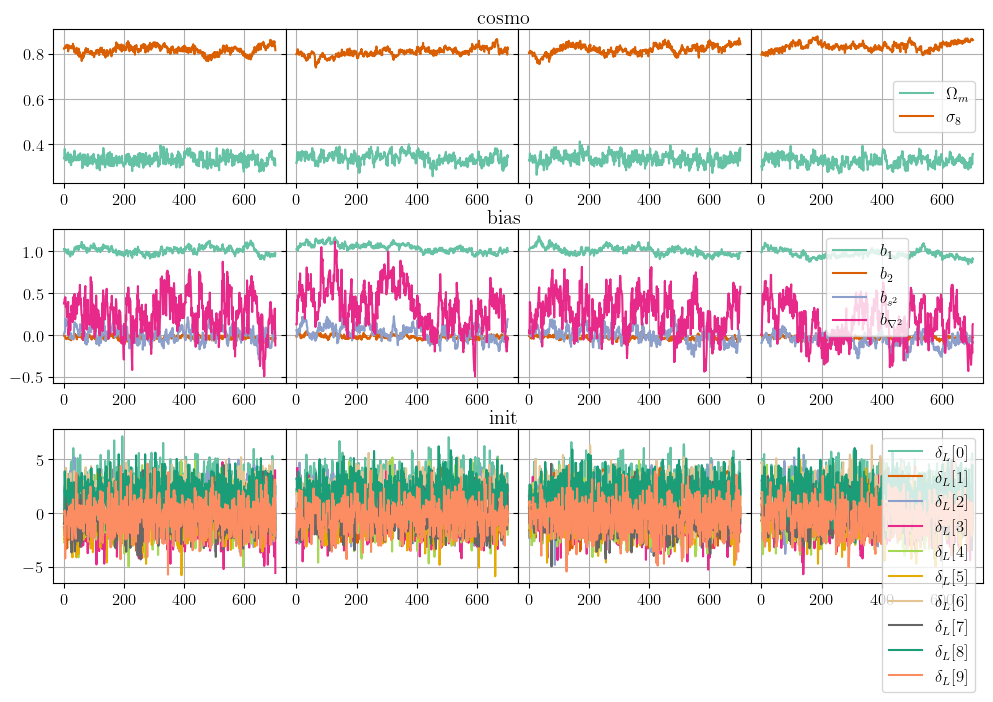

In [17]:
plt.figure(figsize=(12,6))
chains[['*~kptc']].flatten().plot(names)
chains[['*~kptc']].print_summary()

Removed no burn in


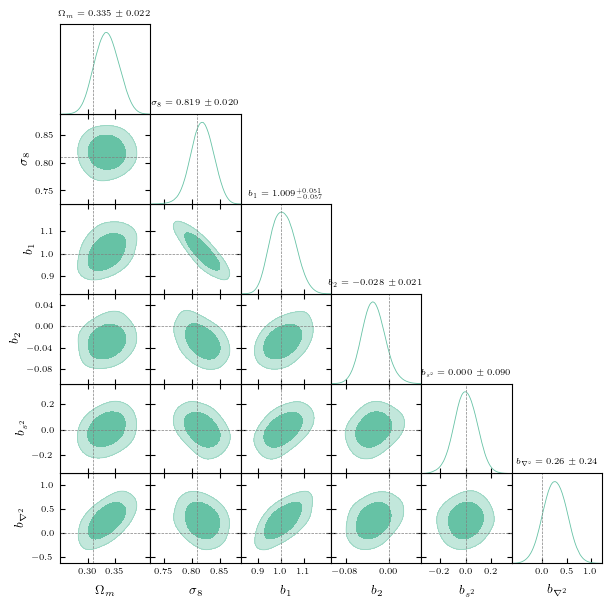

In [18]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)])

### Field-Level case case
Power spectrum should converge close to the truth, and coherence must be on the order of the coherence between truth and obs

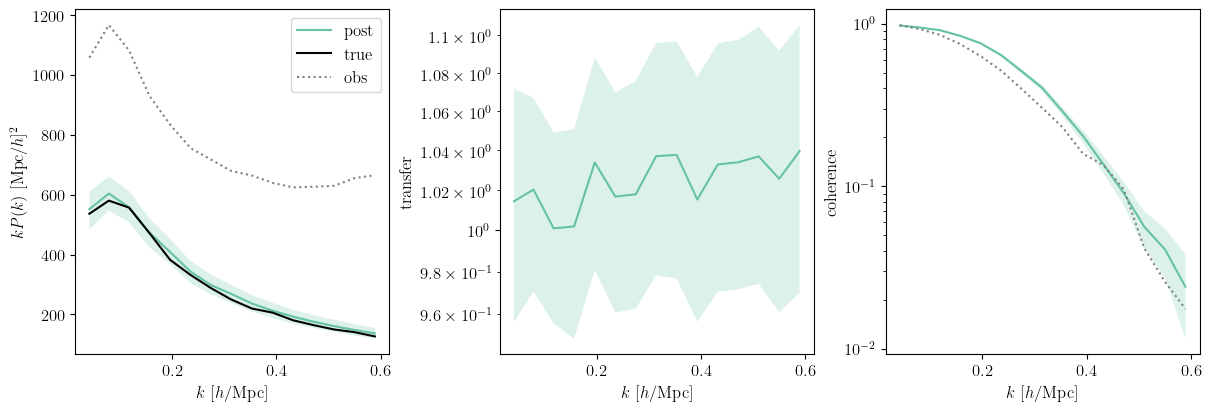

In [19]:
prob = 0.95
log = False

plt.figure(figsize=(12, 4), layout="constrained")
kptc = tree.map(jnp.concatenate, chains['kptc'])
plot_powtranscoh(*jnp.median(jnp.stack(kptc), 1), log=log, label='post')
plot_powtranscoh(*kptc, log=log, fill=prob)

plt.subplot(131)
plot_pow(*pow0, 'k', log=log, label='true')
plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
plt.legend()

plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')

## Example 2: quantify MCMC performance

### Number of eval per effective sample should converge. If so, that's a relevant metric.

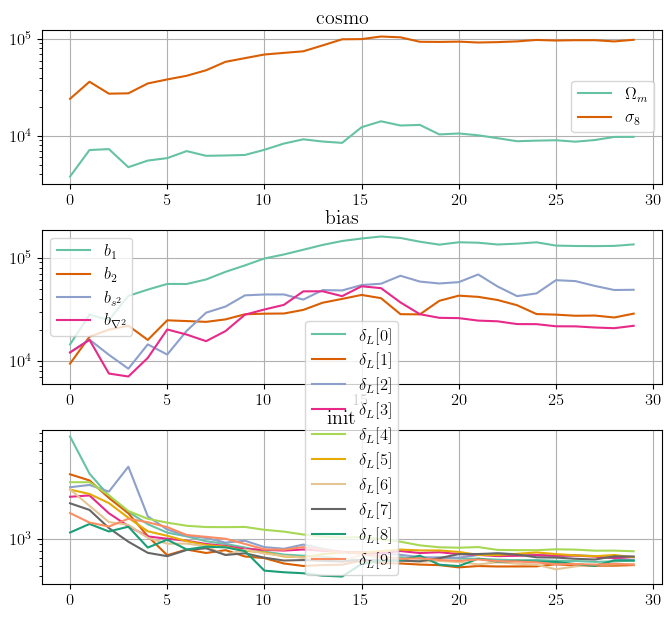

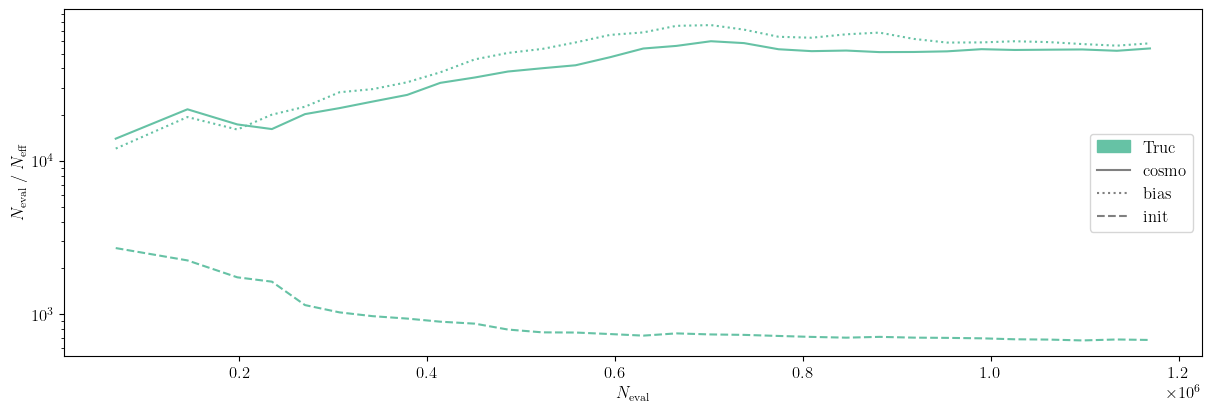

In [ ]:
plt.figure(figsize=(8, 6))
chains[['*~kptc']].flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, 1, log=True)

labels = ['Truc']
metrics = []
cumess = chains[['*~kptc']].stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn(metrics, labels):
    plt.figure(figsize=(12, 4), layout="constrained")
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn(metrics, labels)
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");